In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.patches import Patch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


In [173]:


data = pd.read_excel("TOTAL_DATA_FINAL.xlsx", index_col="Squad").drop(columns = ['xGD', 'KP'])

data = data.loc[ (data.league == 'serie_a') | (data.league == 'la_liga') | (data.league == 'premier')].drop(columns = ['league'])

cutoff = int(len(data)*.5)

football_train = data[:cutoff]
football_test = data[cutoff:]



In [192]:


label_types = np.select([data["Rk"].values <= 4, 
                          (data["Rk"].values > 4) & (data["Rk"].values <= 15), 
                          #(data["Rk"].values > 7) & (data["Rk"].values <= 16),
                          data["Rk"].values > 15], [1,2,3])



data_train = data[:cutoff]
data_test = data[cutoff:]



In [193]:

X_features = data[[i for i in data.columns if i != "Rk" and i != "ok"]]
Y_Test = label_types

pca = PCA(n_components=6)

PC_data = pca.fit_transform(X_features)
PC_train = PC_data[:cutoff]
PC_test = PC_data[cutoff:]

labels = label_types[:cutoff]
labels_test = label_types[cutoff:]

In [194]:

fit = KNeighborsClassifier(n_neighbors=17).fit(PC_train, labels)

predicted = fit.predict(PC_test)


labels_with_index = pd.Series(labels_test, index = data_test.index)


means_3 = np.mean(PC_test[:,2])
means_4 = np.mean(PC_test[:,3])
means_5 = np.mean(PC_test[:,4])
means_6 = np.mean(PC_test[:,5])


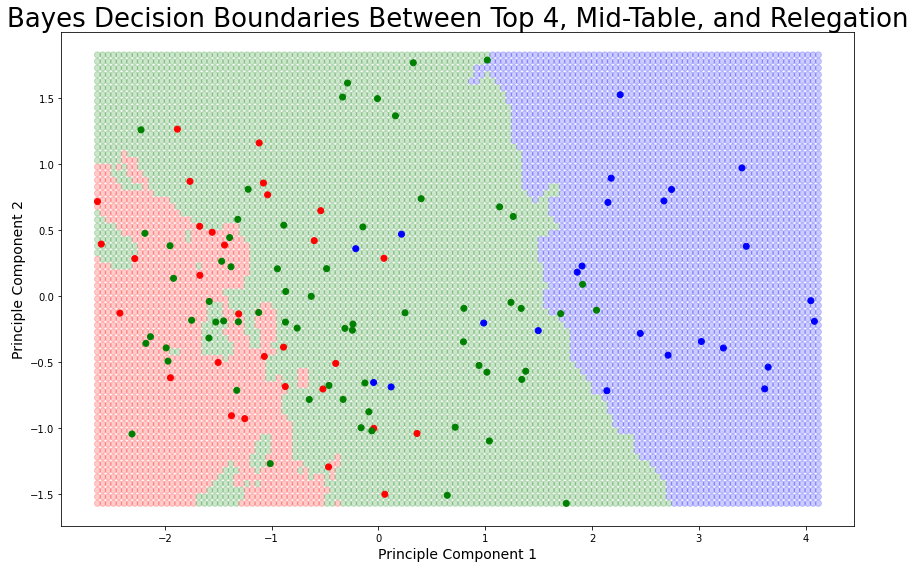

In [196]:

colors_top_4 = {1 : "blue", 2: 'green', 3 : "red"}

ygrid = np.arange(min(PC_test[:,0]), max(PC_test[:,0])+.05,.05)
xgrid = np.arange(min(PC_test[:,1]),max(PC_test[:,1])+.05,.05)
xax, yax = np.meshgrid(xgrid, ygrid, indexing="ij")
z = np.zeros(xax.shape)
for i in range(len(xgrid)):
    for j in range(len(ygrid)):
        x = np.array([ygrid[j], xgrid[i], means_3, means_4, means_5, means_6])
        z[i,j]= fit.predict(x[np.newaxis,:])

colorsnum = {1 : "blue", 2: 'green', 3 : "red"}
c = [colorsnum[i] for i in z.reshape(-1)]

plt.figure(figsize=(12,8))
plt.scatter(yax,xax, color=c, alpha=.2)
plt.scatter(PC_test[:,0], PC_test[:,1], color = labels_with_index.map(colors_top_4))
plt.xlabel("Principle Component 1", size = 14)
plt.ylabel("Principle Component 2", size = 14)
plt.title("Bayes Decision Boundaries Between Top 4, Mid-Table, and Relegation", size = 26)
plt.tight_layout()

Text(0, 0.5, 'accuracy')

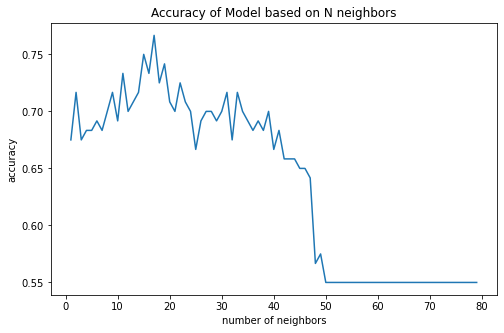

In [197]:

def get_k(n, X, Y):
    
    fit_p3 = KNeighborsClassifier(n_neighbors=n).fit(PC_train, labels)
    pred = fit_p3.predict(X)
    return (np.sum(np.equal(pred, Y)) / len(X))


accs = {}

for n in range(1, 80):

    accs[n] = get_k(n, PC_test, labels_test)

plt.figure(figsize=(8,5))
plt.plot(list(accs.keys()), list(accs.values()))
plt.title("Accuracy of Model based on N neighbors")
plt.xlabel("number of neighbors")
plt.ylabel("accuracy")